# Train and evaluate Kan models for study case 1

Here we use KAN models for non-linear WQI applications

In [1]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[1]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc

from datetime import datetime, timedelta

import torch
# from kan import KAN, create_dataset
from kan import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Project imports ===
from scripts.plot_setup import configure_plots

# === Plotting configuration ===
_ = configure_plots()

# === Set seed globaly ===
from scripts.reproducibility import set_global_seed
seed = 42
set_global_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Load Dataset for training

In [2]:
# Load processed data

path2file = Path('data/processed')

filename = Path('clean_filtered_pond_iot_2023.csv')

df_WQ = pd.read_csv(PROJECT_ROOT /path2file / filename)
df_WQ

,Unnamed: 0,created_date,water_pH,TDS,water_temp,WA_WQI,WQM,RMS_WQI
0,0,2023-01-30 12:00:00,6.448000,287.600000,23.880000,12.215376,21.207222,12.243995
1,1,2023-01-30 12:01:00,6.444373,287.614667,23.880000,12.152570,21.256673,12.272546
2,2,2023-01-30 12:02:00,6.446986,287.622373,23.880000,12.197797,21.221015,12.251958
3,3,2023-01-30 12:03:00,6.445146,290.989926,23.880000,12.162970,21.243438,12.264904
4,4,2023-01-30 12:04:00,6.439843,290.930127,23.880000,12.071205,21.316128,12.306872
...,...,...,...,...,...,...,...,...
12956,12956,2023-02-08 11:56:00,6.864941,339.101660,24.935648,45.282923,37.407061,21.596977
12957,12957,2023-02-08 11:57:00,6.864442,339.079627,24.935735,45.276440,37.409680,21.598489
12958,12958,2023-02-08 11:58:00,6.863953,339.058034,24.935821,45.270088,37.412249,21.599972
12959,12959,2023-02-08 11:59:00,6.863474,339.036873,24.935904,45.263862,37.414771,21.601428


## Create model inputs and outputs

In [3]:
# -----------------------------------------------------------
# 📊 Extract Input and Output Data for Symbolic Regression
# -----------------------------------------------------------

from scripts.preprocessing import compute_quality_ratings

water_pH, TDS, water_temp = df_WQ['water_pH'].values, df_WQ['TDS'].values, df_WQ['water_temp'].values

# ======== Here we will use quality ratings as KAN inputs
# Compute quality ratings (q_i)
q_pH, q_TDS, q_Temp = compute_quality_ratings(water_pH, TDS, water_temp)

# 🔹 Input Variables (features):
# Select the columns to be used as predictors for WQI
# These represent environmental water quality measurements
# xData = df_WQ[['water_pH', 'water_temp', 'TDS']].values
xData = np.array([q_pH, q_Temp, q_TDS]).T#/100

# 🔹 Output Variable (target):
# The Weighted Quadratic Mean (WQM)
# This is the value we want to model via symbolic regression
wqi_type = 'WQM' 
yData = df_WQ[wqi_type].values

# 🔹 Timestamp:
# Extract datetime for each observation to support temporal slicing
date = pd.to_datetime(df_WQ['created_date'].values)

# Extract date information from the DataFrame
time_date = pd.to_datetime(date)

# Total number of samples in the dataset
nsamples = len(yData)

# -----------------------------------------------------------
# 🔁 Split data into Training, Validation, and Testing Sets
# -----------------------------------------------------------

# Assuming time-ordered data sampled at 1-minute resolution
samples_per_day = 24 * 60  # 1 day = 1440 samples

# Define durations
n_train = samples_per_day * 6       # 6 days for training
n_val = nsamples - n_train #samples_per_day * 3 // 2    # 1.5 days for validation
# n_test = nsamples - (n_train + n_val)  # remainder for testing

# Optional check
# assert n_test > 0, "Not enough samples to allocate test set after train and validation splits."

# Training set
x_train = xData[:n_train, :]
y_train = yData[:n_train]
date_train = date[:n_train]

# Validation set
x_val = xData[n_train:, :] # [n_train:n_train + n_val, :]
y_val = yData[n_train:]
date_val = date[n_train:]

# Testing set
# x_test = xData[n_train + n_val:, :]
# y_test = yData[n_train + n_val:]
# date_test = date[n_train + n_val:]

# print(f'Split: Train {n_train}, Validation {n_val}) and Test {n_test} samples')
print(f'Split: Train {n_train}, Validation {n_val}. Hold-out train ratio: {n_train/nsamples:.2f}, validation ratio: {n_val/nsamples:.2f}')


Split: Train 8640, Validation 4321. Hold-out train ratio: 0.67, validation ratio: 0.33


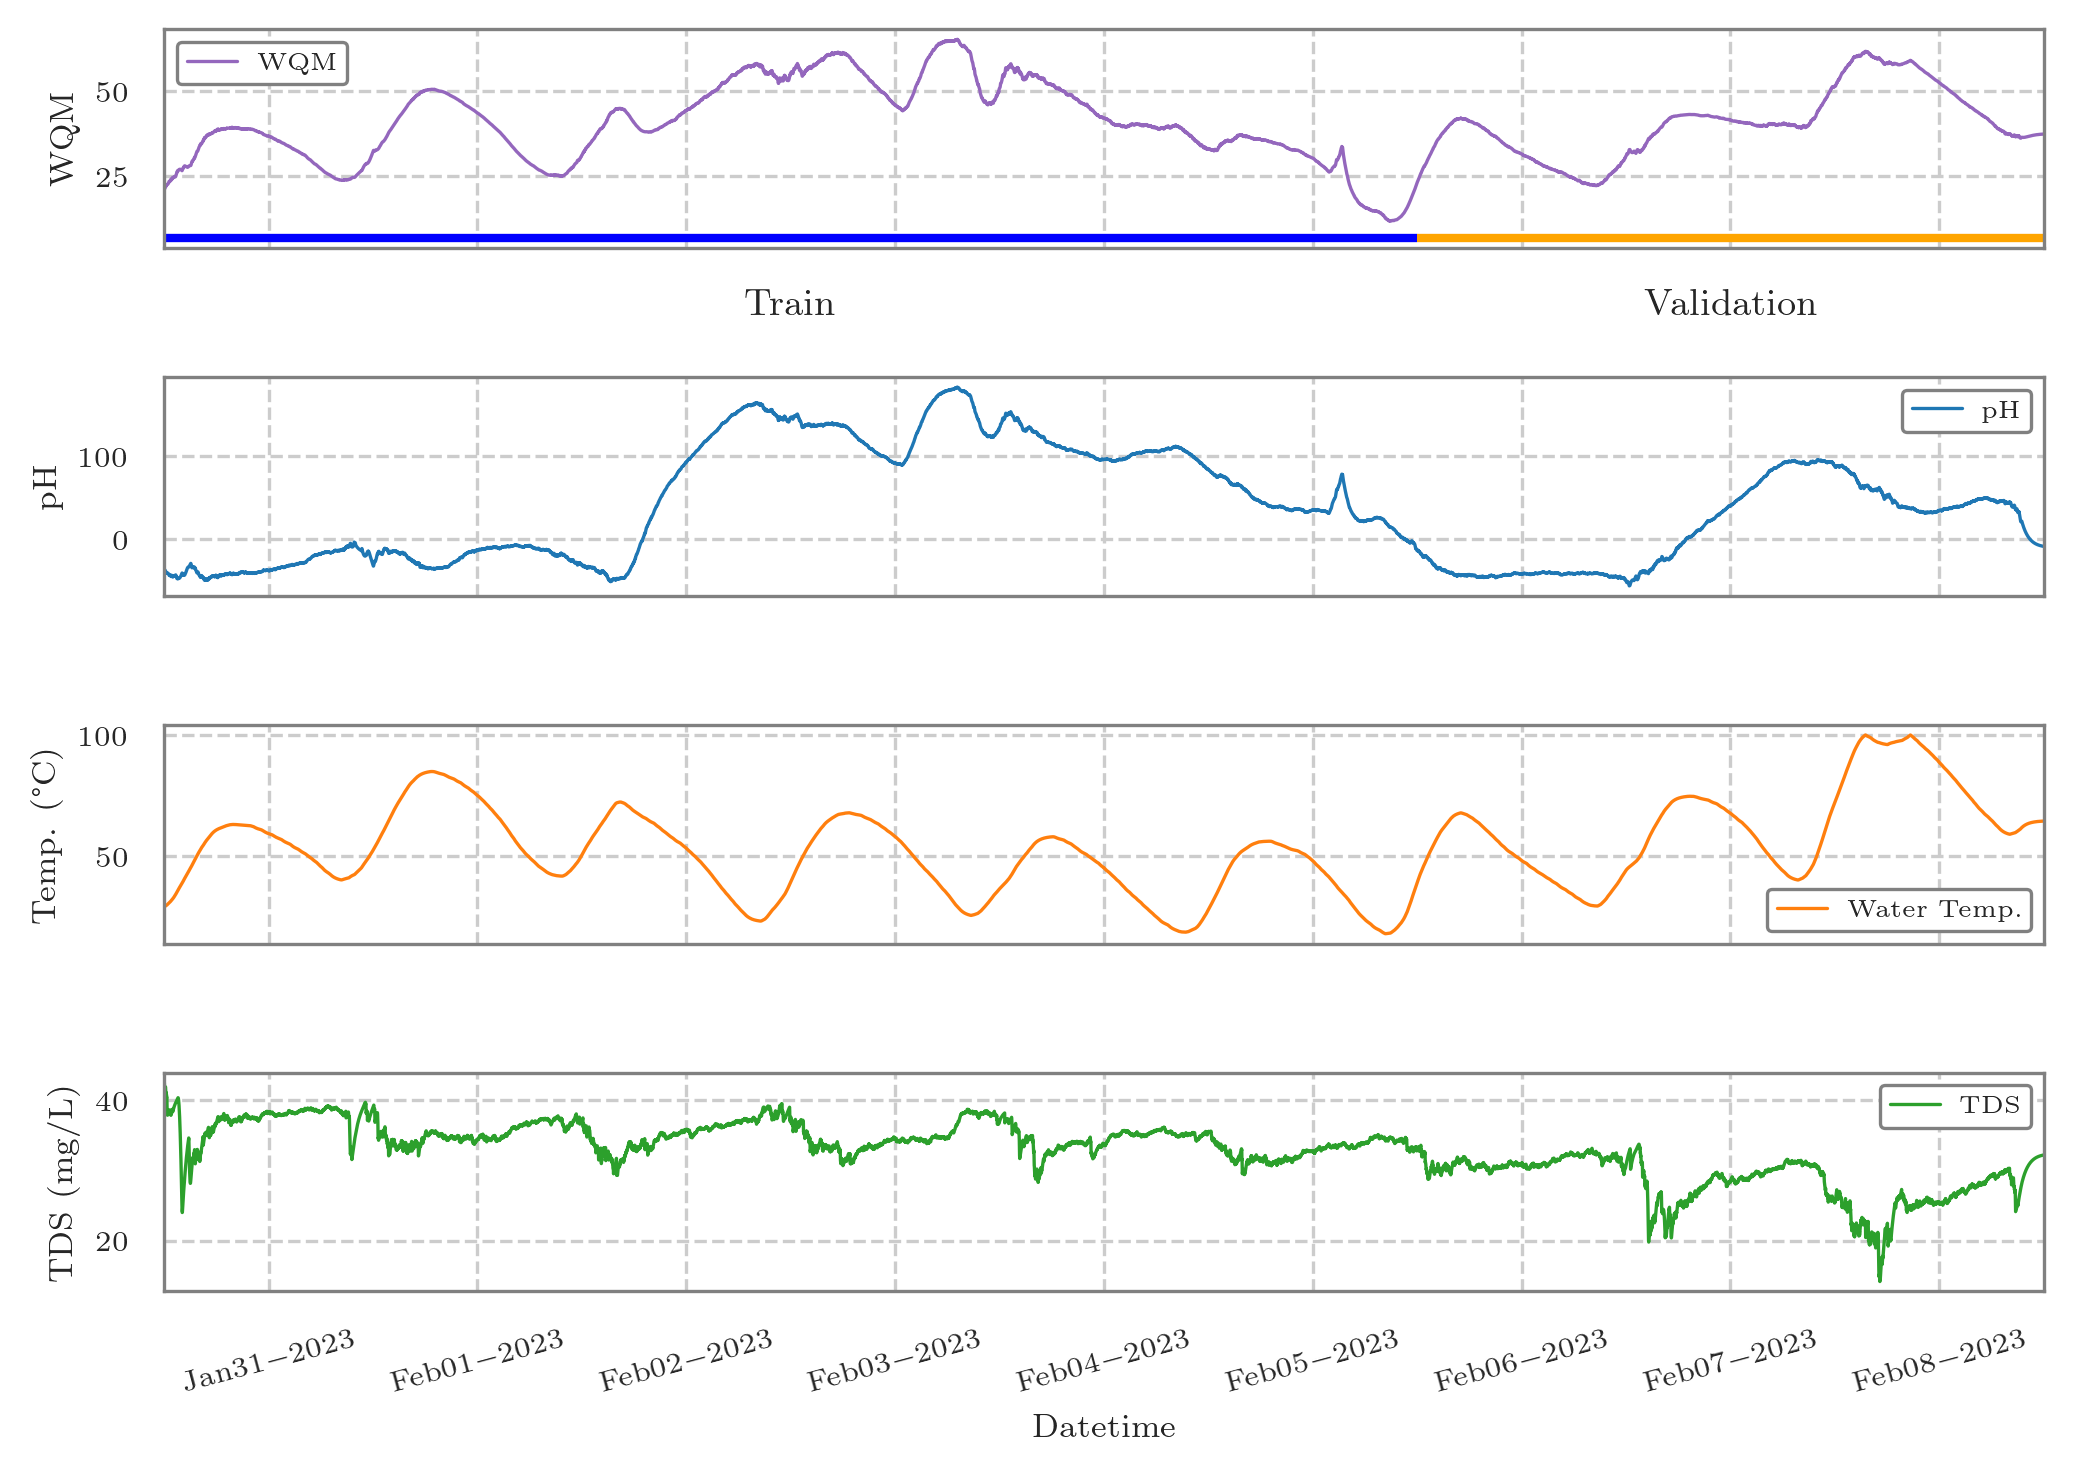

In [4]:
# Set up the figure with 4 subplots (stacked vertically)
fig, axs = plt.subplots(4, 1, figsize=(7, 5), sharex=True)  # sharex=True to share the datetime axis

# predict_symb_01 = lambda x: 17.3102* x[:, 0] + 24.5182 * x[:, 1] - 684.922

# yData_pred = predict_symb_01(xData)

# Water Quality Index (WQI) - Moved to the first subplot (axs[0])
axs[0].plot(date, yData , color='tab:purple', linewidth=0.8, label=wqi_type)
# axs[0].plot(date, yData_pred , color='k', linewidth=0.5, label='Pred_WQI')
axs[0].set_ylabel(wqi_type)
axs[0].set_xlim((date[0], date[-1]))

# Add horizontal line bars to indicate Train, Validation, and Test splits
WQI = df_WQ[wqi_type].values
y_line = min(yData ) - 5  # Position of the line slightly above the max WQI


# Add horizontal line segments with labels
axs[0].hlines(y_line, date[0], date[n_train], colors='blue', linewidth=2)#, label='Train')
axs[0].hlines(y_line, date[n_train], date[n_train + n_val - 1], colors='orange', linewidth=2)#, label='Validation')
# axs[0].hlines(y_line, date[n_train + n_val], date[-1], colors='purple', linewidth=2)#, label='Test')

# Positioning the labels in the middle of each segment
axs[0].text(date[n_train // 2], y_line - 25 , 'Train', ha='center', va='bottom', fontsize=9)
axs[0].text(date[n_train + n_val // 2], y_line - 25, 'Validation', ha='center', va='bottom', fontsize=9)
# axs[0].text(date[n_train + n_val + n_test // 2], y_line - 25, 'Test', ha='center', va='bottom', fontsize=9)

axs[0].grid(True)
axs[0].legend()

# Water pH
axs[1].plot(date, xData[:,0], color='tab:blue', linewidth=0.8, label='pH')
axs[1].set_ylabel('pH')
axs[1].grid(True)
axs[1].legend()

# TDS (Total Dissolved Solids)
axs[2].plot(date, xData[:,1], color='tab:orange', linewidth=0.8, label='Water Temp.')
axs[2].set_ylabel('Temp. (°C)')
axs[2].grid(True)
axs[2].legend()

# Water Temperature
axs[3].plot(date, xData[:,2], color='tab:green', linewidth=0.8, label='TDS')
axs[3].set_ylabel('TDS (mg/L)')
axs[3].set_xlabel('Datetime')
axs[3].grid(True)
axs[3].legend()

# Format x-tick labels in the last subplot
axs[3].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b%d-%Y'))
axs[3].tick_params(axis='x', rotation=15)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
# fig_path = results_fig_dir / '11_Dataset_Split_WQM.pdf'
# fig.savefig(fig_path, format='pdf')

# Show the plot
plt.show()

In [5]:
# Convert input features to torch tensors
train_input = torch.tensor(x_train, dtype=torch.float32)
val_input   = torch.tensor(x_val, dtype=torch.float32)
# test_input  = torch.tensor(x_test, dtype=torch.float32)

# Convert output labels to torch tensors (as column vectors)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32)
val_label   = torch.tensor(y_val[:, None], dtype=torch.float32)
# test_label  = torch.tensor(y_test[:, None], dtype=torch.float32)

dataset_train_val = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': val_input,
    'test_label': val_label
}

## Train Original model

In [6]:
# Create KAN
# model = KAN(width=[3,3,1], grid=5, k=3, seed = 42, device=device)
model_00 = KAN(width=[3,3,1], grid=7, k=3, seed = 42, device=device)

# Train KAN
results = model_00.fit(dataset_train_val,
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()) 

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.58e-01 | test_loss: 2.95e+00 | reg: 1.51e+01 | : 100%|█| 50/50 [01:29<00:00,  1.78s/

saving model version 0.1


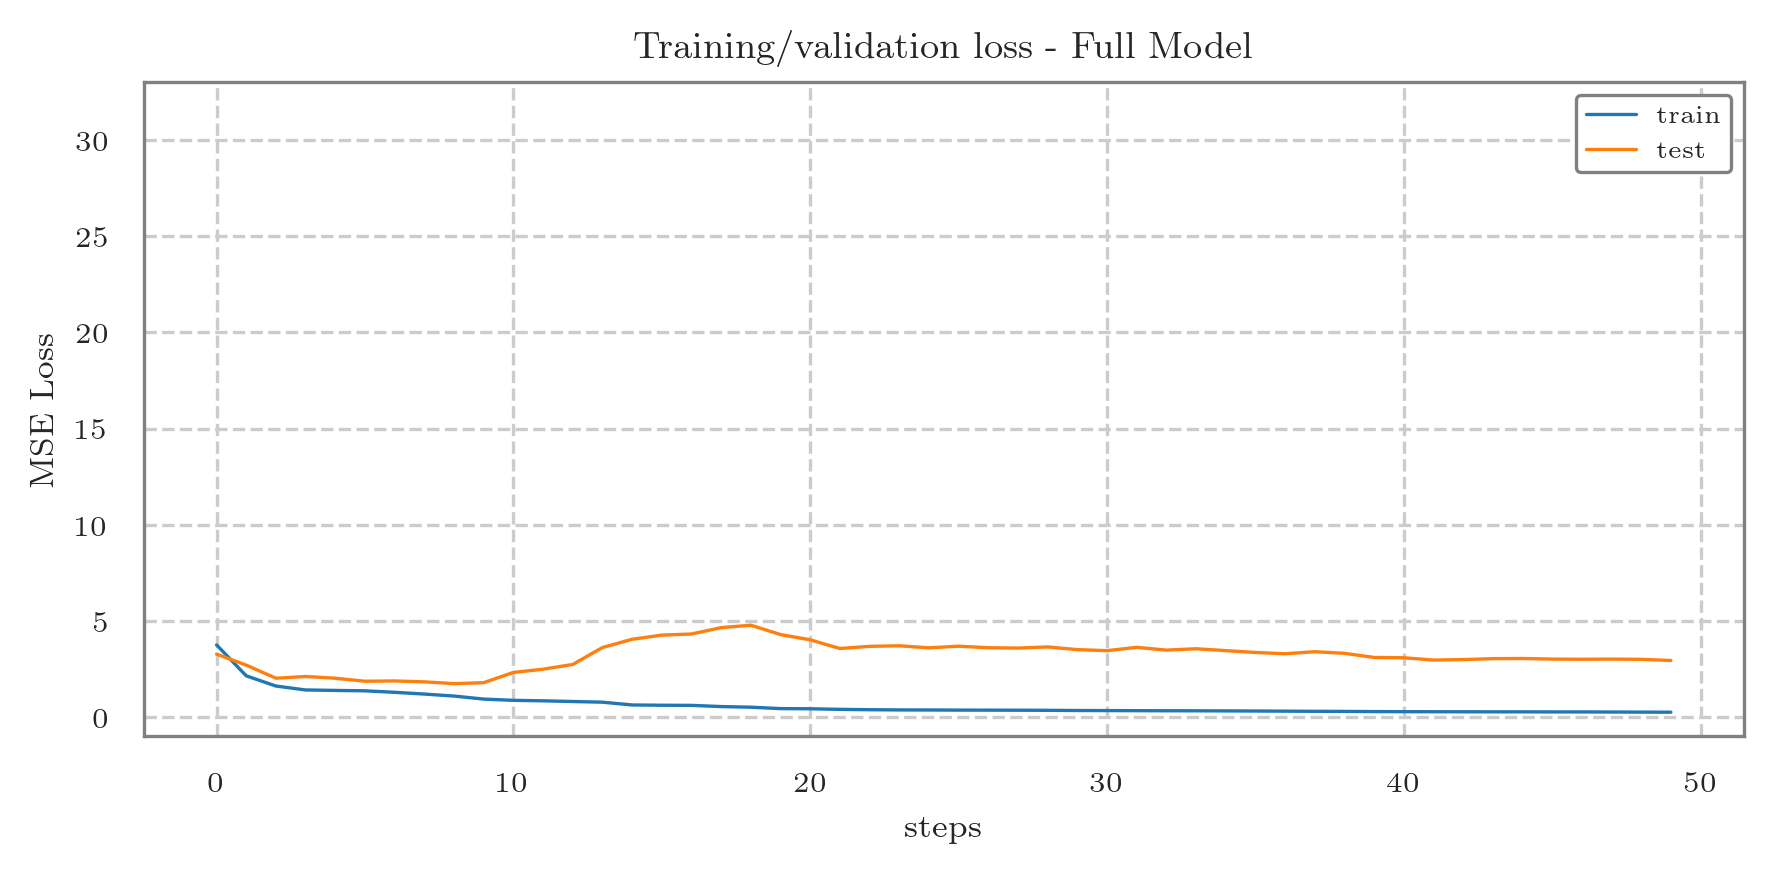

In [7]:
train_loss = results['train_loss']
test_loss = results['test_loss']

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(train_loss, linewidth = 0.8,label = 'train')
ax.plot(test_loss, linewidth = 0.8,label = 'test')
ax.set_ylim(-1,33)
ax.set_xlabel('steps')
ax.set_ylabel('MSE Loss')
ax.set_title('Training/validation loss - Full Model')
ax.legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
# fig_path = results_fig_dir / '12_Train_Val_Loss-Full-Model_WQM.pdf'
# fig.savefig(fig_path, format='pdf')

plt.show()

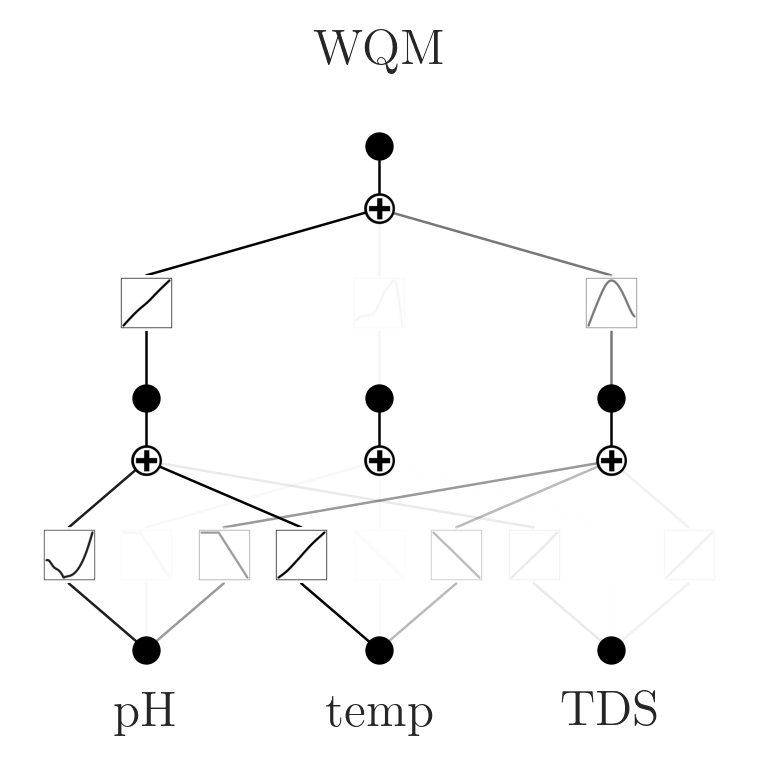

In [8]:
# model(dataset['train_input'])
# model = model.prune_input(active_inputs=[0,1])
model_00.plot( in_vars=['pH', 'temp', 'TDS'], out_vars=[wqi_type], scale=0.3)#, title = 'Original model')

# Access the most recent active figure
fig = plt.gcf()

# Save the figure
# fig_path = results_fig_dir / '13_kan_model_full_WQM.pdf'
# fig.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=600)


### Extract simbolic expression for full model

 Step 2 — Extract symbolic expression (non-destructive)

In [9]:
# # ✅ 1. Rewind model BEFORE symbolification
# # Revert to the trained version (e.g., before pruning or previous modifications).
# # This ensures we symbolify a clean model, avoiding mutations to the original.
# model_00_symb = model_00.rewind('0.1')  # Now renamed as version 1.1

# # ✅ 2. Run one forward pass to populate internal activations
# # Required for symbolic substitution, as KAN needs intermediate activations ("acts").
# # Note: We disable gradient tracking for performance and safety during inference.
# model_00_symb.save_act = True
# with torch.no_grad():
#     _ = model_00_symb(train_input)

# # ✅ 3. Apply symbolic substitution (mutates the model!)
# # This step modifies the internal structure of the model by replacing activation functions
# # with symbolic expressions from the provided library. The version is updated to 1.2.
# lib = ['x', 'x^2', 'x^3', 'exp', 'sqrt', 'tanh', 'sin', 'tan', 'abs']
# model_00_symb.auto_symbolic(lib=lib)

# # ✅ 4. Extract and round the symbolic formula
# # We retrieve the resulting symbolic expression and round it for readability.
# formula = model_00_symb.symbolic_formula()[0][0]
# print(ex_round(formula, 4))

# # 📌 IMPORTANT NOTE:
# # The method `auto_symbolic()` mutates the current model instance in-place,
# # meaning it is no longer equivalent to the trained version used for inference or evaluation.
# # Therefore, it's recommended to rewind or load the desired pre-symbolic version,
# # apply symbolic substitution, and extract formulas only on that temporary copy.


In [10]:
# 🔢 Define symbolic predictor (manually extracted from the trained full KAN)
# -0.0017*x_1 + 0.4342*x_2 + 0.0556*x_3 + 0.0303*(1 - 0.2314*x_1)**2 + 5.5336*sin(0.0152*x_1 + 0.021*x_2 - 0.0228*x_3 + 0.5853) + 2.6867
predict_symb = lambda x: (
    -0.0017 * x[:, 0]
    + 0.4342 * x[:, 1]
    + 0.0556 * x[:, 2]
    + 0.0303 * (1 - 0.2314 * x[:, 0]) ** 2
    + 5.5336 * np.sin(0.0152 * x[:, 0] + 0.021 * x[:, 1] - 0.0228 * x[:, 2] + 0.5853)
    + 2.6867
)

# predict_symb = lambda x: (
#     -0.0048 * x[:, 0]
#     + 0.4238 * x[:, 1]
#     + 0.0738 * x[:, 2]
#     + 0.075 * (1 - 0.1476 * x[:, 0]) ** 2
#     - 13.0692 * np.sin(0.0078 * x[:, 0] + 0.0088 * x[:, 1] - 0.0172 * x[:, 2] - 1.8703)
#     - 5.2736
# )

# 📌 Different random seeds may result in slight numerical variations in the symbolic expressions.

## Pruned model

In [11]:
# Prune edges
model_01 = model_00.rewind('0.1') # Return to the original (3 inputs) trained model, renamed as 2.1


model_01 = model_01.prune(edge_th=4e-2) # saving model version 1.2
model_01 = model_01.prune_input(active_inputs = [0,1]) # saving model version 1.3

rewind to model version 0.1, renamed as 1.1
saving model version 1.2
saving model version 1.3


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 1.25e+00 | reg: 6.35e+00 | : 100%|█| 50/50 [01:14<00:00,  1.49s/


saving model version 0.1


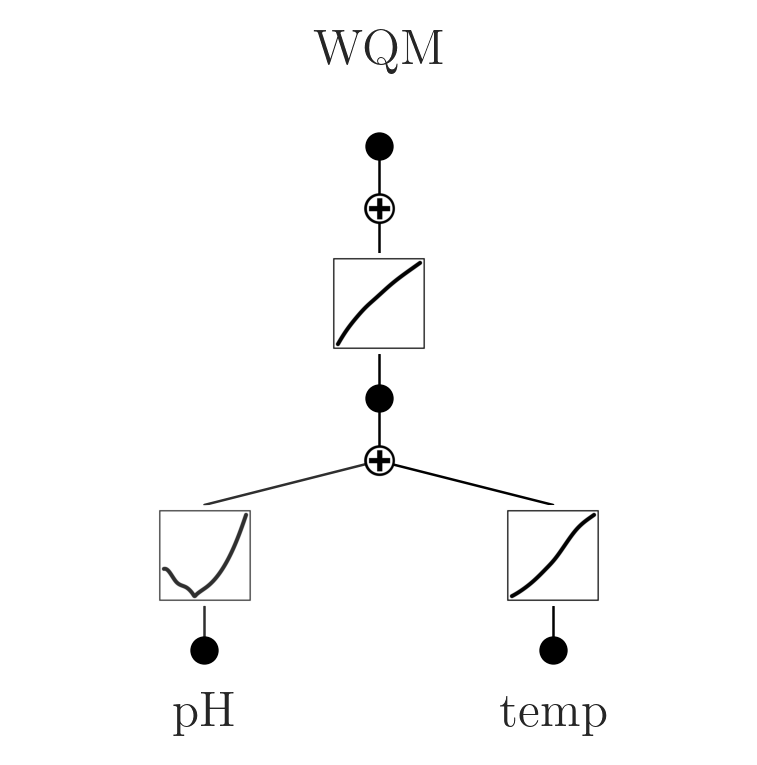

In [12]:
# Train pruned model
dataset_tain_val_01 = {
    'train_input': train_input[:,:2],
    'train_label': train_label,
    'test_input': val_input[:,:2],
    'test_label': val_label
}

# Create KAN
model_01 = KAN(width=[2,1,1], grid=7, k=3, seed = 42, device=device)

# Train KAN, continue traning the prunned model
results_01 = model_01.fit(dataset_tain_val_01,
                      opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()) 

model_01.plot( in_vars=['pH', 'temp'], out_vars=[wqi_type], scale=0.3)#, title = 'Original model')

# Access the most recent active figure
# fig = plt.gcf()


# # # Save the figure
# fig_path = results_fig_dir / '13a_kan_model_pruned_02.pdf'
# fig.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=600)


In [13]:
# -------------------------------------------------
# 1) Ensure the checkpoint directory exists
# -------------------------------------------------
ckpt_path = Path("./pruned_model")           # folder that will hold the file
ckpt_path.mkdir(parents=True, exist_ok=True) # silently does nothing if it’s there

# -------------------------------------------------
# 2) Save the model
# -------------------------------------------------
model_01.saveckpt(ckpt_path / "prune_kan")

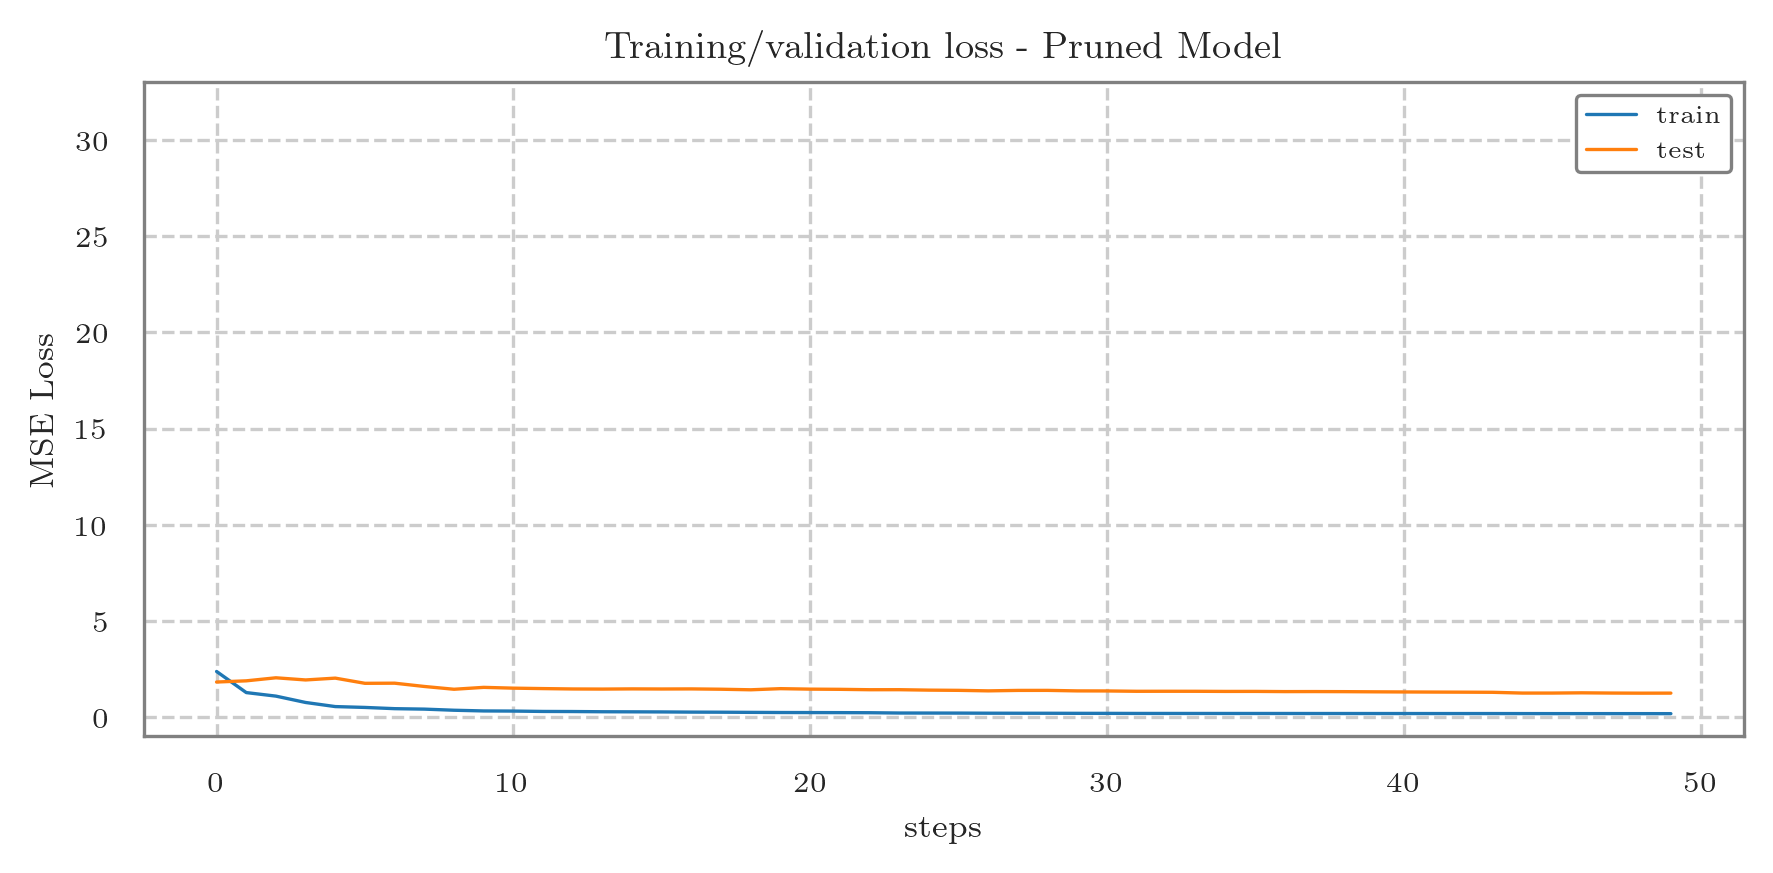

In [14]:
train_loss = results_01['train_loss']
test_loss = results_01['test_loss']

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(train_loss, linewidth = 0.8,label = 'train')
ax.plot(test_loss, linewidth = 0.8,label = 'test')
ax.set_ylim(-1,33)
ax.set_xlabel('steps')
ax.set_ylabel('MSE Loss')
ax.set_title('Training/validation loss - Pruned Model')
ax.legend()

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the figure
# fig_path = results_fig_dir / '14_Train_Val_Loss-Pruned-Model_02.pdf'
# fig.savefig(fig_path, format='pdf')

plt.show()

## Extract symbolic expression for pruned model

In [15]:
# ✅ 1. Rewind model BEFORE symbolification
# Revert to the trained version (e.g., before pruning or previous modifications).
# This ensures we symbolify a clean model, avoiding mutations to the original.
model_01_symb = model_01.rewind('0.1')  # Now renamed as version 2.3

# ✅ 2. Run one forward pass to populate internal activations
# Required for symbolic substitution, as KAN needs intermediate activations ("acts").
# Note: We disable gradient tracking for performance and safety during inference.
model_01_symb.save_act = True
with torch.no_grad():
    _ = model_01_symb(train_input)

# ✅ 3. Apply symbolic substitution (mutates the model!)
# This step modifies the internal structure of the model by replacing activation functions
# with symbolic expressions from the provided library. The version is updated to 1.2.
lib = ['x', 'x^2', 'x^3', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'tan', 'abs']
model_01_symb.auto_symbolic(lib=lib)

# ✅ 4. Extract and round the symbolic formula
# We retrieve the resulting symbolic expression and round it for readability.
formula = model_01_symb.symbolic_formula()[0][0]
print(ex_round(formula, 4))

# 📌 IMPORTANT NOTE:
# The method `auto_symbolic()` mutates the current model instance in-place,
# meaning it is no longer equivalent to the trained version used for inference or evaluation.
# Therefore, it's recommended to rewind or load the desired pre-symbolic version,
# apply symbolic substitution, and extract formulas only on that temporary copy.


rewind to model version 0.1, renamed as 1.1
fixing (0,0,0) with x^2, r2=0.9995196461677551, c=2
fixing (0,1,0) with x^2, r2=0.9996078014373779, c=2
fixing (1,0,0) with sqrt, r2=0.9997055530548096, c=2
saving model version 1.2
11.7795*sqrt(0.0009*(-x_1 - 0.7979)**2 + 0.0079*(-0.5697*x_2 - 1)**2 + 1) - 4.0626


In [34]:
# # 🔢 Define symbolic predictor (manually extracted from the trained pruned KAN)
# 11.7795*sqrt(0.0009*(-x_1 - 0.7979)**2 + 0.0079*(-0.5697*x_2 - 1)**2 + 1) - 4.0626
predict_symb_01 = lambda x: (
    11.7795*np.sqrt(
        0.0009*(x[:,0] + 0.7979)**2 +
        0.0079*(0.5697*x[:,1] + 1)**2 + 1
    )
    - 4.0626
)

# predict_symb_01 = lambda x: (
#     11.7642*np.sqrt(
#         0.0009*(-x[:,0] - 0.9895)**2 +
#         0.0073*(-0.5975*x[:,1]- 1)**2 + 1
#     )
#     - 4.0678
# )

# 📌 Different random seeds may result in slight numerical variations in the symbolic expressions.

In [33]:
(11.7795**2)*0.0079

1.0961772999750004

## Evaluating model inference and symbolic expressions

After training the **KAN model** for the case study 2 (using all three original input features), we extracted their respective symbolic expression. These expressions provide closed-form mathematical representations of the learned mappings from inputs to the predicted Water Quality Index, that in the study case 2 we named Water Qadratic Mean:

\begin{equation}
    WQM = \sqrt{\sum_{i=1}^N(w_i \times q_i^2)}
\end{equation}

By using symbolic expressions, the KAN framework enables interpretable predictions without relying on the full model architecture at inference time.

To evaluate the performance of the two predictors — the trained KAN model and its corresponding symbolic form — we computed standard regression metrics: **R²**, **MAE**, and **RMSE**. These metrics were calculated separately for the **train**, **validation**, and **test** datasets.

The results were compiled into a single DataFrame, where:
- Columns represent the metrics (`R2`, `MAE`, `RMSE`)
- Rows correspond to each evaluation set (train/val/test) for each predictor
- An additional column indicates the **predictor type** (KAN model or symbolic expression)

The final performance table was saved as a CSV file in the following path:

models/model_cards/kan_performance_summary_02.csv




In [35]:
# ----------------------------------------
# 🧪 Evaluate and save KAN model performance
# ----------------------------------------

from scripts.evaluation import compute_metrics
model_pruned = model_01

# ----------------------------------------------------
# 🔮 Predict WQI using forward pass of trained KAN model
# ----------------------------------------------------
print(val_input.shape)
# Note: .detach() removes the output from the computation graph (for PyTorch models)
train_preds = model_00.forward(train_input).detach().cpu().numpy()
val_preds   = model_00.forward(val_input).detach().cpu().numpy()
# test_preds  = model_00.forward(test_input).detach().cpu().numpy()

train_preds_pruned = model_01.forward(train_input[:, :2]).detach().cpu().numpy()
val_preds_pruned   = model_01 .forward(val_input[:, :2]).detach().cpu().numpy()
# train_preds_pruned = model_01.forward(train_input).detach().cpu().numpy()

# Ground truth labels
train_labels = train_label.cpu().numpy()
val_labels   = val_label.cpu().numpy()
# test_labels  = test_label.cpu().numpy()

# ------------------------------------------------
# 🧮 Compute metrics for symbolic KAN expressions
# ------------------------------------------------

# Apply symbolic functions to NumPy input arrays
train_preds_symb_full  = predict_symb(train_input.cpu().numpy())
val_preds_symb_full    = predict_symb(val_input.cpu().numpy())
# test_preds_symb_full   = predict_symb_full(test_input.cpu().numpy())

train_preds_symb_pruned = predict_symb_01(train_input[:, :2].cpu().numpy())
val_preds_symb_pruned   = predict_symb_01(val_input[:, :2].cpu().numpy())
# test_preds_symb_pruned  = predict_symb_pruned(test_input[:, :2].cpu().numpy())

metrics = []
dict = [
    ("KAN (full)",      train_labels, train_preds),
    ("KAN (full)",      val_labels, val_preds),
    # ("KAN (full)",      test_labels, test_preds),
    ("Symbolic (full)", train_labels, train_preds_symb_full),
    ("Symbolic (full)", val_labels, val_preds_symb_full),
    # ("Symbolic (full)", test_labels, test_preds_symb_full),
    ("KAN (pruned)",    train_labels, train_preds_pruned),
    ("KAN (pruned)",    val_labels, val_preds_pruned),
    # ("KAN (pruned)",    test_labels, test_preds_pruned),
    ("Symbolic (pruned)", train_labels, train_preds_symb_pruned),
    ("Symbolic (pruned)", val_labels, val_preds_symb_pruned)
    # ("Symbolic (pruned)", test_labels, test_preds_symb_pruned),
]
# Append results in a structured way
for label, y_true, y_pred in dict:
    # print(label)
    r2, mae, rmse = compute_metrics(y_true, y_pred)
    metrics.append({
        "Predictor": label,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })


# Assign dataset labels
dataset_labels = ["Train", "Val"] * 4 # ["Train", "Val", "Test"]
df_kan_performance = pd.DataFrame(metrics)
df_kan_performance["Dataset"] = dataset_labels

# Reorder columns
df_kan_performance = df_kan_performance[["Predictor", "Dataset", "R2", "MAE", "RMSE"]]

# --------------------------
# 💾 Save to CSV
# --------------------------

path_performance_summary = PROJECT_ROOT / Path('models/model_cards/02_kan_performance_WQM.csv')
df_kan_performance.to_csv(path_performance_summary, index=False)

# ✅ Print results summary
print('Preformance metrics from train, and validation sets:')
print(df_kan_performance)

print('\nPreformance metrics from validation set:')
test_idx = df_kan_performance['Dataset'] == 'Val'
df_kan_test_performance = df_kan_performance.loc[test_idx,:].reset_index(drop=True)
df_kan_test_performance


torch.Size([4321, 3])
Preformance metrics from train, and validation sets:
           Predictor Dataset        R2       MAE      RMSE
0         KAN (full)   Train  0.999540  0.192659  0.258164
1         KAN (full)     Val  0.914898  1.727288  2.947068
2    Symbolic (full)   Train  0.986681  1.064443  1.389300
3    Symbolic (full)     Val  0.901158  2.089779  3.176064
4       KAN (pruned)   Train  0.999770  0.130074  0.182470
5       KAN (pruned)     Val  0.984699  0.584811  1.249618
6  Symbolic (pruned)   Train  0.998721  0.328114  0.430504
7  Symbolic (pruned)     Val  0.999666  0.152487  0.184528

Preformance metrics from validation set:


,Predictor,Dataset,R2,MAE,RMSE
0,KAN (full),Val,0.914898,1.727288,2.947068
1,Symbolic (full),Val,0.901158,2.089779,3.176064
2,KAN (pruned),Val,0.984699,0.584811,1.249618
3,Symbolic (pruned),Val,0.999666,0.152487,0.184528


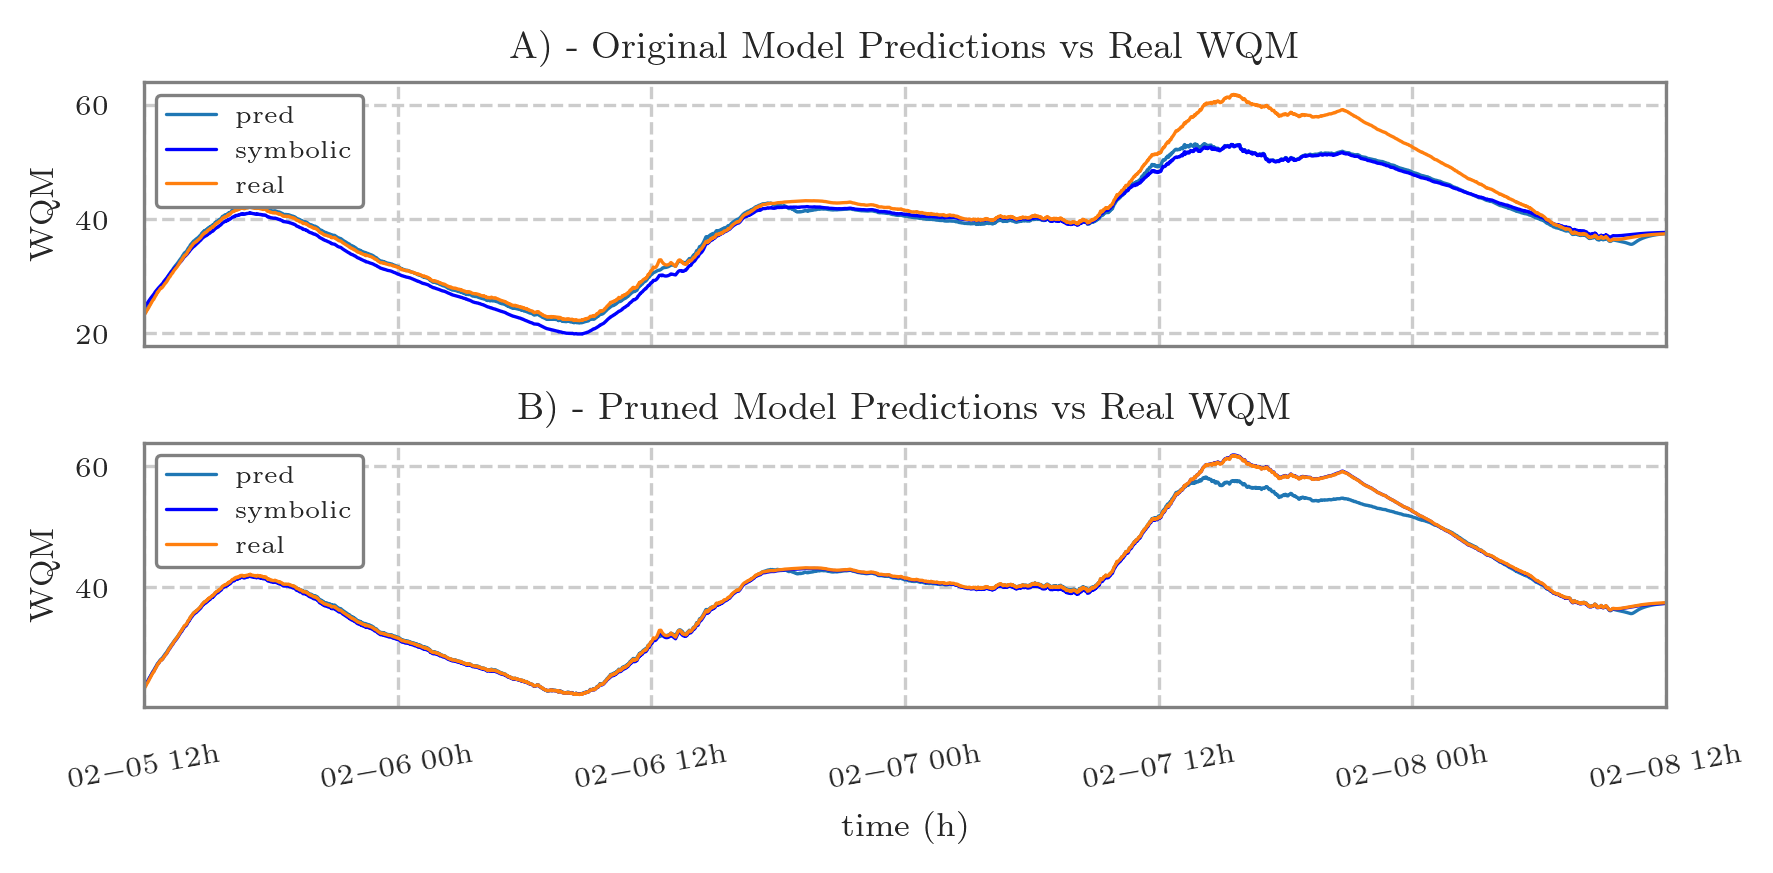

In [36]:
import os

# Create a figure with two subplots (one for each model)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

# Extract date information from the DataFrame
date = pd.to_datetime(df_WQ['created_date'])
time_date = pd.to_datetime(date)
# test_preds_symb_full

ax = ax1
ax.plot(time_date.iloc[n_train:], val_preds, linewidth = 0.8,label = 'pred')
ax.plot(time_date.iloc[n_train:], val_preds_symb_full, linewidth = 0.8, color = 'blue',label = 'symbolic')
ax.plot(time_date.iloc[n_train:], val_labels, linewidth = 0.8,label = 'real')
# ax.set_xlabel('time steps')
ax.set_ylabel(wqi_type)
ax.set_title(f'A) - Original Model Predictions vs Real {wqi_type}')
ax.legend()

ax = ax2
ax.plot(time_date.iloc[n_train:], val_preds_pruned, linewidth = 0.8,label = 'pred') # , color = 'green'
ax.plot(time_date.iloc[n_train:], val_preds_symb_pruned, linewidth = 0.8, color = 'blue',label = 'symbolic')
ax.plot(time_date.iloc[n_train:], val_labels, linewidth = 0.8,label = 'real')
ax.set_xlabel('time (h)')
ax.set_ylabel(wqi_type)
ax.set_title(f'B) - Pruned Model Predictions vs Real {wqi_type}')
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %Hh'))
ax.tick_params(axis='x', rotation=10)

t0, t1 = time_date.iloc[n_train], time_date.iloc[-1]
ax.set_xlim((t0, t1))

fig.tight_layout()

# Save the figure
# fig_path = results_fig_dir / '14_KAN-Performance-Hold-Out_Test_WQM.pdf'
# fig.savefig(fig_path, format='pdf')

plt.show()

# Explore variable selection

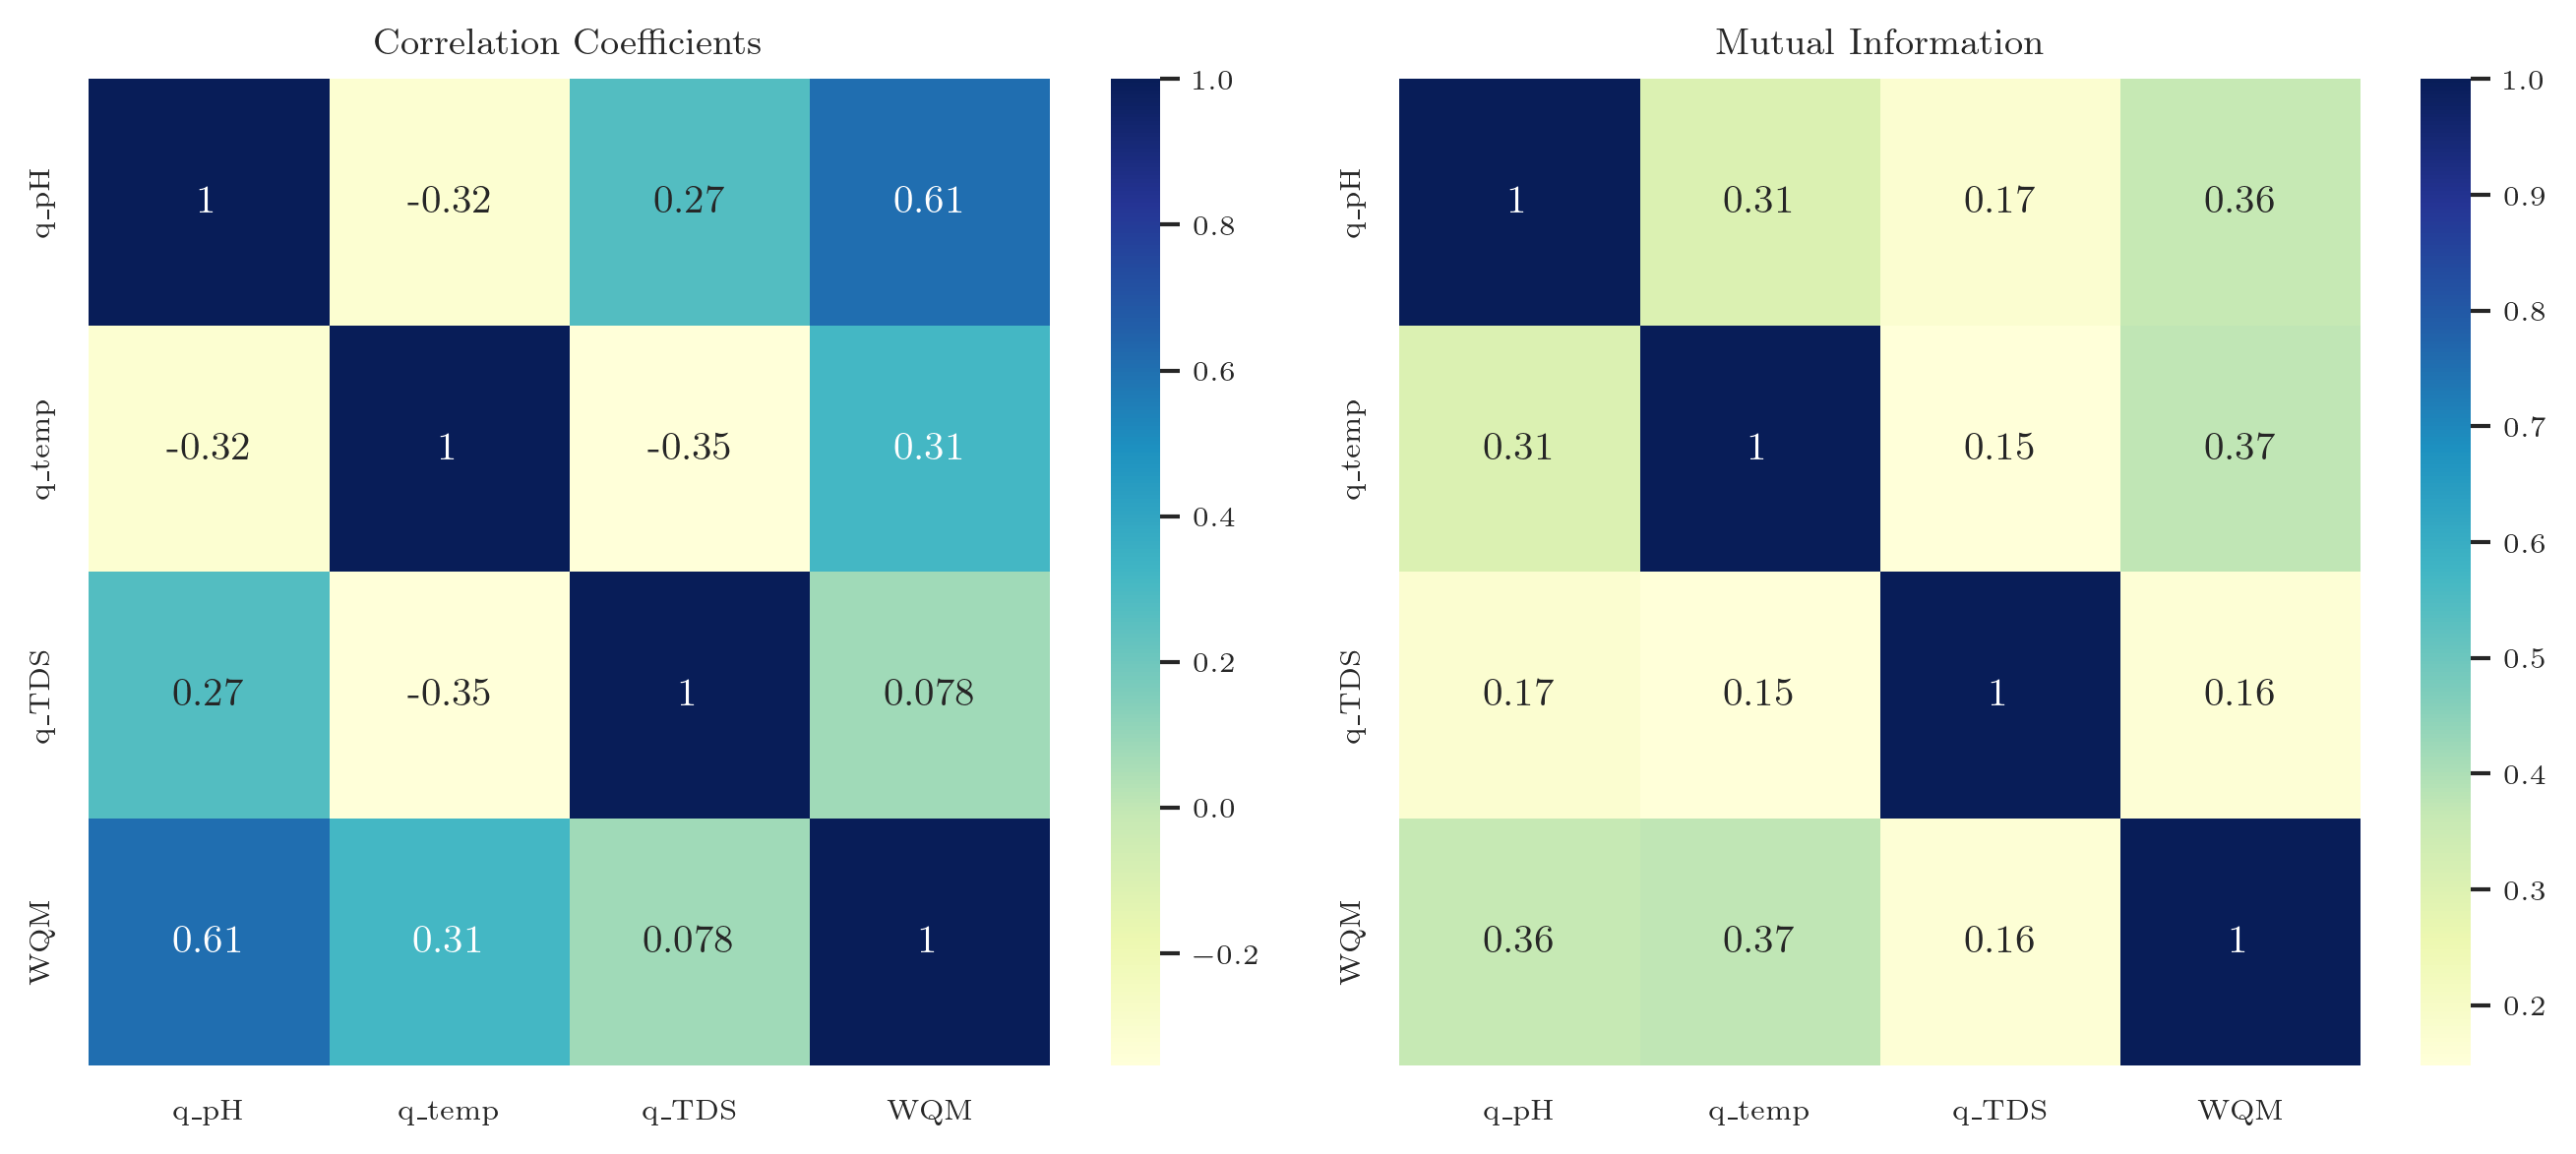

In [31]:
# Feature EDA

import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

# Select relevant variables and slice training + validation set: Using non-normalized water parameters
# variables = ['water_pH', 'water_temp', 'TDS',wqi_type]
# df_analysis = df_WQ.iloc[:n_train + n_val//2][variables[:-1]].copy()

variables = ['q_pH', 'q_temp', 'q_TDS',wqi_type]
df_analysis = pd.DataFrame(np.array([q_pH, q_Temp, q_TDS]).T, columns=variables[:-1])
df_analysis = df_analysis.iloc[:n_train + n_val//2,:]


df_analysis[wqi_type] = WQI[:n_train + n_val//2]

# 1. Correlation Coefficient Matrix
corr_matrix = df_analysis.corr(method='spearman')

# 2. Mutual Information Matrix (with Normalization)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_analysis), columns=variables)
mi_matrix = np.zeros((len(variables), len(variables)))
entropies = np.zeros(len(variables))

# Compute mutual information and entropy (diagonal)
for i, target in enumerate(variables):
    entropies[i] = mutual_info_regression(df_scaled[[target]], df_scaled[target])[0]
    for j, feature in enumerate(variables):
        mi = mutual_info_regression(df_scaled[[feature]], df_scaled[target])[0]
        mi_matrix[i, j] = mi

# Normalize using sqrt(H(X) * H(Y))
nmi_matrix = np.zeros_like(mi_matrix)
for i in range(len(variables)):
    for j in range(len(variables)):
        if entropies[i] > 0 and entropies[j] > 0:
            nmi_matrix[i, j] = mi_matrix[i, j] / np.sqrt(entropies[i] * entropies[j])
        else:
            nmi_matrix[i, j] = 0

# Symmetrize NMI matrix
nmi_matrix_sym = (nmi_matrix + nmi_matrix.T) / 2


# 3. Plotting
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', ax=axs[0])
axs[0].set_title('Correlation Coefficients')

sns.heatmap(nmi_matrix_sym, xticklabels=variables, yticklabels=variables,
            annot=True, cmap='YlGnBu', ax=axs[1])
axs[1].set_title('Mutual Information')

fig.tight_layout()

# Save the figure
# fig_path = results_fig_dir / '15_Variable_Heatmaps_WQM.pdf'
# fig.savefig(fig_path, format='pdf')

plt.show()

In [30]:
variables = ['q_pH', 'q_temp', 'q_TDS',wqi_type]
df_analysis = pd.DataFrame(np.array([q_pH, q_Temp, q_TDS]).T, columns=variables[:-1])
df_analysis = df_analysis.iloc[:n_train + n_val//2,:]
df_analysis

,q_pH,q_temp,q_TDS
0,-36.800000,29.333333,42.480000
1,-37.041778,29.333333,42.477067
2,-36.867609,29.333333,42.475525
3,-36.990257,29.333333,41.802015
4,-37.343785,29.333333,41.813975
...,...,...,...
10795,39.535405,68.051484,28.344219
10796,39.705364,68.017788,28.274535
10797,39.651997,67.977432,28.378822
10798,39.456533,67.933035,28.401973


### Temporal cross-validation of KAN models

In this section, we assess the generalization capability of the trained Kolmogorov-Arnold Network (KAN) models using a **temporal cross-validation** framework tailored for time-series data.

Although the models were originally developed and evaluated using a **standard hold-out validation split**, we employ a more rigorous evaluation method based on a **sliding-window cross-validation** strategy. This approach better reflects realistic deployment conditions in which models must generate predictions on sequential, unseen data without access to future observations.

#### 📌 Training and test intervals

The models were trained using historical data within the following period:

* **Training window**: from `2023-01-30 12:00:00` to `2023-02-05 12:00:00`

To validate the model’s temporal robustness, we defined a **temporal cross-validation segment** using a held-out portion of the dataset:

* **Evaluation window**: from `2023-03-01 12:00:00` to `2023-03-08 12:00:00`

#### 🔁 Sliding-window configuration

We implemented a **sliding-window cross-validation** protocol over the held-out test segment using the following parameters:

* **Window size**: 2 days (48 hours) of test data per fold
* **Step size**: 8 hours between the start of each consecutive fold
* **Evaluation horizon**: final 3.5 days of the dataset, from `2023-03-04` to `2023-03-07 12:00:00`

This resulted in a total of **five overlapping test folds**, each simulating prediction in forward-looking time intervals. The 2-day windows slide forward every 8 hours, introducing temporal overlap but always respecting causality — ensuring that training data precedes test data and that no future information is leaked.

#### ✅ Why this matters

This type of **time-aware validation** is essential in domains such as environmental monitoring and IoT-based systems, where conditions evolve over time and models must remain robust to temporal drift. By using overlapping folds in a realistic deployment scenario, we can:

* Capture potential variations in performance due to **temporal shifts**
* Evaluate **model stability** and **robustness** across consecutive intervals
* Avoid data leakage and **preserve temporal integrity** during testing

This evaluation strategy provides a more trustworthy estimate of how the model will behave in production settings when exposed to continuously arriving sensor data.


#### ⬇️ Cross-validation folds used in the held-out March segment: 2-Day Folds with 8h Steps Starting from March 4

| Fold | Start Date & Time   | End Date & Time     | Duration |
| ---- | ------------------- | ------------------- | -------- |
| 1    | 2023-03-04 00:00:00 | 2023-03-05 23:59:00 | 2 days   |
| 2    | 2023-03-04 08:00:00 | 2023-03-06 07:59:00 | 2 days   |
| 3    | 2023-03-04 16:00:00 | 2023-03-06 15:59:00 | 2 days   |
| 4    | 2023-03-05 00:00:00 | 2023-03-06 23:59:00 | 2 days   |
| 5    | 2023-03-05 08:00:00 | 2023-03-07 07:59:00 | 2 days   |

In [22]:
from scripts.preprocessing import select_time_slice_df

# Load processed data

path2file = Path('data/processed')

filename = Path('clean_filtered_pond_iot_2023_crossvalidation.csv')

df_WQ = pd.read_csv(PROJECT_ROOT /path2file / filename)

water_pH, TDS, water_temp = df_WQ['water_pH'].values, df_WQ['TDS'].values, df_WQ['water_temp'].values

# 🔹 Ensure 'created_date' is in datetime format
df_WQ['created_date'] = pd.to_datetime(df_WQ['created_date'])

# 🔹 Compute quality ratings (q_i) — KAN input features
q_pH, q_TDS, q_Temp = compute_quality_ratings(water_pH, TDS, water_temp)
xData = np.array([q_pH, q_Temp]).T  # Features: (N_samples, N_features)
# xData = df_WQ[['water_pH', 'water_temp']].values

# 🔹 Target variable: Water Quality Index (WQI)
wqi_type = 'WQM'
yData = df_WQ[wqi_type].values


In [23]:
# 🔹 Parameters for cross-validation configuration
samples_per_day = 24 * 60               # Sampling rate = 1 sample per minute
fold_length_days = 2                # Duration of each fold in days
step_hours = 8                         # Step size between folds in hours

fold_size = int(samples_per_day * fold_length_days)
step_size = int((step_hours / 24) * samples_per_day)

# 🔹 Compute fold indices
start_indices = np.arange(0, len(df_WQ) - fold_size + 1, step_size)
end_indices = start_indices + fold_size
num_folds = len(start_indices)

# 🔹 Prepare a DataFrame to store validation performance results
cv_results = []

# 🔄 Loop through each validation fold
for k in range(num_folds):
    # Extract time range for current fold
    start_idx = start_indices[k]
    end_idx = end_indices[k]

    start_date = df_WQ['created_date'].iloc[start_idx]
    end_date = df_WQ['created_date'].iloc[end_idx - 1]  # inclusive

    # print(f'Fold {k + 1}: Start = {start_date}, End = {end_date}')

    # Extract time slice (optional if needed for further analysis)
    df_sel = select_time_slice_df(df_WQ, cols=None, start_date=start_date, end_date=end_date)

    # Extract inputs and outputs for current fold
    x_val = xData[start_idx:end_idx, :]
    y_val_true = yData[start_idx:end_idx]

    # Convert inputs to torch tensor
    val_input = torch.tensor(x_val, dtype=torch.float32)

    # Predict using the trained KAN model
    y_val_pred = model_01.forward(val_input).detach().cpu().numpy()

    # Evaluate performance
    r2, mae, rmse = compute_metrics(y_val_true, y_val_pred)

    # Append metrics to result list
    cv_results.append({
        'Fold': k + 1,
        'Model': 'Kan_Pruned',
        'Start': start_date,
        'End': end_date,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    })

# 🔚 Finalize results into DataFrame
df_cv_performance = pd.DataFrame(cv_results)

# Save CV temporal performance evaluation to CSV
filename = '02a_kan-pruned-cv_validation_WQM.csv'
folder = 'models/model_cards'
path_folder = PROJECT_ROOT/Path(folder)/Path(filename)

df_cv_performance.to_csv(path_folder, index=False)

print(f"\nCross-Validation performance summary for the pruned KAN model, target: {wqi_type}.")
df_cv_performance



Cross-Validation performance summary for the pruned KAN model, target: WQM.


,Fold,Model,Start,End,R2,MAE,RMSE
0,1,Kan_Pruned,2023-03-04 00:00:00,2023-03-05 23:59:00,0.965178,2.353731,3.774770
1,2,Kan_Pruned,2023-03-04 08:00:00,2023-03-06 07:59:00,0.980473,1.640519,2.667894
2,3,Kan_Pruned,2023-03-04 16:00:00,2023-03-06 15:59:00,0.981958,1.496985,2.322057
3,4,Kan_Pruned,2023-03-05 00:00:00,2023-03-06 23:59:00,0.923361,3.135733,4.900402
4,5,Kan_Pruned,2023-03-05 08:00:00,2023-03-07 07:59:00,0.744961,5.194810,7.664066


In [24]:
# 🔹 Parameters for cross-validation configuration
samples_per_day = 24 * 60               # Sampling rate = 1 sample per minute
fold_length_days = 2                # Duration of each fold in days
step_hours = 8                         # Step size between folds in hours

fold_size = int(samples_per_day * fold_length_days)
step_size = int((step_hours / 24) * samples_per_day)

# 🔹 Compute fold indices
start_indices = np.arange(0, len(df_WQ) - fold_size + 1, step_size)
end_indices = start_indices + fold_size
num_folds = len(start_indices)

# 🔹 Prepare a DataFrame to store validation performance results
cv_results = []

# 🔄 Loop through each validation fold
for k in range(num_folds):
    # Extract time range for current fold
    start_idx = start_indices[k]
    end_idx = end_indices[k]

    start_date = df_WQ['created_date'].iloc[start_idx]
    end_date = df_WQ['created_date'].iloc[end_idx - 1]  # inclusive

    # print(f'Fold {k + 1}: Start = {start_date}, End = {end_date}')

    # Extract time slice (optional if needed for further analysis)
    df_sel = select_time_slice_df(df_WQ, cols=None, start_date=start_date, end_date=end_date)

    # Extract inputs and outputs for current fold
    x_val = xData[start_idx:end_idx, :]
    y_val_true = yData[start_idx:end_idx]

    # Predict using the trained KAN model
    y_val_pred = predict_symb_01(x_val)

    # Evaluate performance
    r2, mae, rmse = compute_metrics(y_val_true, y_val_pred)

    # Append metrics to result list
    cv_results.append({
        'Fold': k + 1,
        'Model': 'Symb_Pruned',
        'Start': start_date,
        'End': end_date,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    })

# 🔚 Finalize results into DataFrame
df_cv_performance = pd.DataFrame(cv_results)

# Save CV temporal performance evaluation to CSV
filename = '02b_symb-prune-cv_validation_WQM.csv' 
folder = 'models/model_cards'
path_folder = PROJECT_ROOT/Path(folder)/Path(filename)

df_cv_performance.to_csv(path_folder, index=False)

print(f"\nCross-Validation performance summary for the pruned symbolic experssion, target: {wqi_type}.")
df_cv_performance



Cross-Validation performance summary for the pruned symbolic experssion, target: WQM.


,Fold,Model,Start,End,R2,MAE,RMSE
0,1,Symb_Pruned,2023-03-04 00:00:00,2023-03-05 23:59:00,0.997230,0.705742,1.064698
1,2,Symb_Pruned,2023-03-04 08:00:00,2023-03-06 07:59:00,0.997301,0.576698,0.991868
2,3,Symb_Pruned,2023-03-04 16:00:00,2023-03-06 15:59:00,0.999195,0.362925,0.490505
3,4,Symb_Pruned,2023-03-05 00:00:00,2023-03-06 23:59:00,0.999192,0.383141,0.503192
4,5,Symb_Pruned,2023-03-05 08:00:00,2023-03-07 07:59:00,0.999048,0.406377,0.468230
